Available: 47.68 compute units

PNEUMOTHORAX SEGMENTATION USING SIIM-ACR DATASET

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-9b80v2ot
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-9b80v2ot
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit bd7f877fec51309a1a7de7670aed232954450037
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cac

## Importing Libraries

In [3]:
import os
import torch
import csv
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import json
from pathlib import Path
import matplotlib.pyplot as plt
# import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

import torch.nn.functional as F
import torchvision.transforms.functional as TF
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import Sampler
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import torchvision.models as models # NEW MARCH-JUNE EDIT

try:
    from itertools import ifilterfalse
except ImportError:  # py3k
    from itertools import filterfalse

## Config - 1

In [4]:
IMG_SIZE         = 1024
DIR              = "/content/drive/MyDrive/datasets"
DATA_DIR         = Path(DIR)
TRAIN_IMG_DIR    = Path("/content/drive/MyDrive/datasets/train_png")
TRAIN_LBL_DIR    = Path("/content/drive/MyDrive/datasets/mask")
DATA_FRAME_PATH  = "/content/drive/MyDrive/datasets/RLE_kfold.csv"
KFOLD_PATH       = ""
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
BATCH_SIZE       = 8
EPOCHS           = 50
# Path for pretrained model weights
TRAINING_MODEL_PATH = "/content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/m_1024_CHECKPOINTS_epoch15_bst_model1024_fold4_0.8294.tar"
USE_SAMPLER      = True
POSTIVE_PERC     = 0.4
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRETRAINED       = True # False means we're using ImageNet weights, so essentially, it's pretrained & never from scratch!!!!!
LEARNING_RATE    = 0.00001
NUM_WORKERS      = 12
USE_CRIT         = True
FOLD_ID          = 4
EVAL_METRICS      = ["metric - it calculates dice coefficient."]

# Regularization Settings
EARLY_STOPPING_PATIENCE = 12
L2_WEIGHT_DECAY  = 0.000005
GRADIENT_CLIPPING = True
GRADIENT_CLIPPING_THRESHOLD = 0.1 # for model trained on 1024x1024

# IF U DON'T WANT TO CHANGE Learning rate from previous experiment then set this to True.
OPTIMIZER_LOAD = True
# U MUST VERIFY IF LR IS GETTING SET PROPERLY FOR THE SCHEDULER IN THE "OPTIMIZER & SCHEDULER" SECTION OF THE NOTEBOOK.

# Learning Rate Scheduler Settings
SCHEDULER        = "CosineAnnealingWarmRestarts"
if SCHEDULER == "ReduceLROnPlateau":
    SCHEDULER_PARAMS = {'factor': 0.1, 'patience': 2, 'threshold': 0.0000001, 'min_lr': 0.0000001}
elif SCHEDULER == "CosineAnnealingWarmRestarts":
    SCHEDULER_PARAMS = {'T_0': 1, 'T_mult': 2, 'eta_min': 0.0000001}
elif SCHEDULER == "CosineAnnealingLR":
    SCHEDULER_PARAMS = {'T_max': 8, 'eta_min': 0.0000001}

# Thresholds for 1024x1024 is there along with div by 2 values and div by 4 values
TRIPLET_THRESHOLDS = [  [0.6, 500.0, 0.35], [0.67, 500.0, 0.37], [0.75, 500.0, 0.3],
                        [0.75, 500.0, 0.4], [0.75, 1000.0, 0.3], [0.75, 1000.0, 0.4],
                        [0.6, 1000.0, 0.3], [0.6, 1000.0, 0.4], [0.6, 1500.0, 0.3],
                        [0.6, 1500.0, 0.4], [0.6, 250.0, 0.35], [0.67, 250.0, 0.37],
                        [0.75, 250.0, 0.3], [0.75, 250.0, 0.4], [0.75, 500.0, 0.3],
                        [0.75, 500.0, 0.4], [0.6, 500.0, 0.3], [0.6, 500.0, 0.4],
                        [0.6, 750.0, 0.3], [0.6, 750.0, 0.4], [0.6, 1000, 0.35],
                        [0.67, 1000, 0.37], [0.75, 1000, 0.3], [0.75, 1000, 0.4],
                        [0.75, 2000, 0.3], [0.75, 2000, 0.4], [0.6, 2000, 0.3],
                        [0.6, 2000, 0.4], [0.6, 3000, 0.3], [0.6, 3000, 0.4]       ]


"""
    "-------------------------------SAVING losses & metrics-------------------------------------"
"""
ACCOUNT         = "Neeshanth" # "Neeshanth" or "wonder_boys" or others
PURPOSE         = "Model1024_HPT_attempting_better_convergence" # HPT_Exploration/HPT_Finetuning/training/inference/hyperparameter-tuning or hpt OR ANYTHING MORE SPECIFIC
EXP_NO          = 'ATT_4.1_BS_8' # hpt experiment with changed settings
PHASE           = "3_step_1_explore"

EFFECTIVE_BATCH_SIZE = 8 # accumulation_steps * BATCH_SIZE


if ACCOUNT == "Neeshanth":
    # Save Config.txt file
    CONFIG_FILE_LOC = f"/content/drive/MyDrive/Saved Models/model1024/{PURPOSE}_EXP_{EXP_NO}_PHASE_{PHASE}/Config.txt"

    # Save model checkpoint using early stopping class
    model_checkpoint_path = f"/content/drive/MyDrive/Saved Models/model1024/{PURPOSE}_EXP_{EXP_NO}_PHASE_{PHASE}/m_{IMG_SIZE}_CHECKPOINTS"

    # Save batch wise comboloss during training
    store_batch_training_details_path = f"/content/drive/MyDrive/Saved Models/model1024/{PURPOSE}_EXP_{EXP_NO}_PHASE_{PHASE}/{PURPOSE}_train_m{IMG_SIZE}_b{EFFECTIVE_BATCH_SIZE}"
    name_of_batch_training_details_csv = f"{PURPOSE}_TRAIN_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_epoch_" # epoch no. will be added to the end

    # Save batch wise comboloss during validation
    store_batch_validation_details_path = f"/content/drive/MyDrive/Saved Models/model1024/{PURPOSE}_EXP_{EXP_NO}_PHASE_{PHASE}/{PURPOSE}_vali_m{IMG_SIZE}_b{EFFECTIVE_BATCH_SIZE}"
    name_of_batch_validation_details_csv = f"{PURPOSE}_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_Validation_Metrics"

    # Save epoch wise train and val losses to monitor overfitting
    save_progress_path = f"/content/drive/MyDrive/Saved Models/model1024/{PURPOSE}_EXP_{EXP_NO}_PHASE_{PHASE}/{PURPOSE}_progress.csv"

    # Save epoch wise dice coefficient
    save_dice_score_path = f"/content/drive/MyDrive/Saved Models/model1024/{PURPOSE}_EXP_{EXP_NO}_PHASE_{PHASE}/{PURPOSE}_dice_scores.csv"

    # Save bce, dice & focal losses separately after training is done
    save_3losses_path = f"/content/drive/MyDrive/Saved Models/model1024/{PURPOSE}_EXP_{EXP_NO}_PHASE_{PHASE}/{PURPOSE}_all_loss_values.csv"

    # Save best thresholds & their dice scores - done according to Triplet Scheme of Binarization
    save_best_thresholds_path = f"/content/drive/MyDrive/Saved Models/model1024/{PURPOSE}_EXP_{EXP_NO}_PHASE_{PHASE}/{PURPOSE}_best_checkpoint_thresholds.csv"

if ACCOUNT == "wonder_boys":
    # Save batch wise comboloss during training
    store_batch_training_details_path = "/content/drive/MyDrive/Saved Models/Model_{EXP_NO}/hpt_train_m512_b32"
    name_of_batch_training_details_csv = f"{PURPOSE}_TRAIN_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_epoch_" # epoch no. will be added to the end

    # Save batch wise comboloss during validation
    store_batch_validation_details_path = f"/content/drive/MyDrive/Saved Models/Model_{EXP_NO}/hpt_vali_m512_b32"
    name_of_batch_validation_details_csv = f"{PURPOSE}_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_Validation_Metrics"

    # Save epoch wise train and val losses to monitor overfitting
    save_progress_path = f"/content/drive/MyDrive/Saved Models/Model_{EXP_NO}/{PURPOSE}_progress.csv"

    # Save epoch wise dice coefficient
    save_dice_score_path = f"/content/drive/MyDrive/Saved Models/Model_{EXP_NO}/{PURPOSE}_dice_score.csv"

    # Save bce, dice & focal losses separately after training is done
    save_3losses_path = f"/content/drive/MyDrive/Saved Models/Model_{EXP_NO}/{PURPOSE}_all_loss_vals.csv"

    # Save model checkpoint using early stopping class - CREATE A NEW FOLDER
    model_checkpoint_path = f"/content/drive/MyDrive/Saved Models/Model_{EXP_NO}/m_{IMG_SIZE}_CHECKPOINTS"

    # Save best thresholds & their dice scores - done according to Triplet Scheme of Binarization
    save_best_thresholds_path = f"/content/drive/MyDrive/Saved Models/Model_{EXP_NO}/{PURPOSE}_best_checkpoint_thresholds.csv"

if ACCOUNT == "pc_aathesh":
    # Save batch wise comboloss during training
    store_batch_training_details_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\Model_{EXP_NO}\\hpt_train_m512_b32"
    name_of_batch_training_details_csv = f"{PURPOSE}_TRAIN_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_epoch_" # epoch no. will be added to the end

    # Save batch wise comboloss during validation
    store_batch_validation_details_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\Model_{EXP_NO}\\hpt_vali_m512_b32"
    name_of_batch_validation_details_csv = f"{PURPOSE}_{IMG_SIZE}_b_{EFFECTIVE_BATCH_SIZE}_Validation_Metrics"

    # Save epoch wise train and val losses to monitor overfitting
    save_progress_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\Model_{EXP_NO}\\hpt_vali_m512_b32\\{PURPOSE}_progress.csv"

    # Save epoch wise dice coefficient
    save_dice_score_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\Model_{EXP_NO}\\{PURPOSE}_dice_score.csv"

    # Save bce, dice & focal losses separately after training is done
    save_3losses_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\Model_{EXP_NO}\\{PURPOSE}_all_loss_vals.csv"

    # Save model checkpoint using early stopping class - CREATE A NEW FOLDER
    model_checkpoint_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\Model_{EXP_NO}\\m_{IMG_SIZE}_CHECKPOINTS"

    # Save best thresholds & their dice scores - done according to Triplet Scheme of Binarization
    save_best_thresholds_path = f"C:\\Users\\aathe\\Google Drive - Wonder Boys\\Saved Models\\Model_{EXP_NO}\\{PURPOSE}_best_checkpoint_thresholds.csv"

## Saving Config as .txt - TYPE ESSENTIAL DETAILS TO RECOVER THIS EXPERIMENT IN THE BELOW SNIPPET

ESSENTIALS include current_notebook_loc_in_pc, previous_notebook_loc_in_pc, key_changes

In [5]:
from datetime import datetime
import pytz

# Define the IST timezone
ist_timezone = pytz.timezone('Asia/Kolkata')

# Get the current time in IST
ist_time = datetime.now(ist_timezone)

# Format the date and time to DD-MM-YYYY HH:MM:SS
formatted_ist_time = ist_time.strftime("%d-%m-%Y %H:%M:%S")

# Print the formatted IST time
print("Current IST date and time is:", formatted_ist_time)


Current IST date and time is: 07-07-2024 20:35:04


In [6]:
# Define your hyper-parameters as a dictionary
hyperparameters = {
    'image_size': f"{IMG_SIZE}x{IMG_SIZE}",
    'date': formatted_ist_time,
    'account': ACCOUNT,
    'purpose': PURPOSE,
    'experiment_no': EXP_NO,
    'current_notebook_loc_in_pc': "C:/Users/nisha/Desktop/Research Project March-June/03_07_2024/Model1024/Phase_3_step_1_EXP_4.1_CosineAnnealingWarmRestarts_08_07_2024_1_PM/Model1024_HPT_EXP_ATT4_CosineAnnealingWarmRestarts_40_epochs_07_07_2024_2_PM.ipynb",
    'previous_notebook_loc_in_pc': "C:/Users/nisha/Desktop/Research Project March-June/03_07_2024/Model1024/Phase_3_step_1_EXP_4_CosineAnnealingWarmRestarts_07_07_2024_8_PM/Model1024_HPT_EXP_ATT4_CosineAnnealingWarmRestarts_40_epochs_07_07_2024_2_PM.ipynb",
    'key_changes': "Pretrained = ATT_4_BS_8 with 0.8294, OPTIMIZER_LOAD = True, IMG_SIZE = 1024, EARLY_STOPPING_PATIENCE = 12, epochs=50, NUM_WORKERS=12, GRADIENT_CLIPPING: 0.1, BATCH_SIZE=8, SCHEDULER='CosineAnnealingWarmRestarts', POSTIVE_PERC=0.4, LEARNING_RATE = 0.00001, L2_WEIGHT_DECAY  = 0.000005",
    'checkpoint_used_loc': TRAINING_MODEL_PATH,
    'is_optimizer_loaded': OPTIMIZER_LOAD,
    'learning_rate': LEARNING_RATE,
    'batch_size': EFFECTIVE_BATCH_SIZE,
    'gradient_accumulation_steps': int(EFFECTIVE_BATCH_SIZE/BATCH_SIZE),
    'num_epochs': EPOCHS,
    'IsSamplerUsed': USE_SAMPLER,
    'percentage_of_positive_samples': POSTIVE_PERC,
    'optimizer': 'Adam',
    'loss_function': 'ComboLoss',
    'scheduler': SCHEDULER,
    'scheduler_params': SCHEDULER_PARAMS,
    'L2_Regularization_weight_decay':L2_WEIGHT_DECAY,
    'early_stopping_patience': EARLY_STOPPING_PATIENCE,
    'is_gradient_clipping_used': GRADIENT_CLIPPING,
    'gradient_clipping_threshold': GRADIENT_CLIPPING_THRESHOLD,
    'model': 'U-Net with ResNet34 encoder with scSE attention',
    'training_phase': f"Phase - {PHASE}",
    'fold_ID': FOLD_ID,
    'GPU_name': torch.cuda.get_device_name(torch.cuda.current_device()),
    'num_workers': NUM_WORKERS,
    'weights_given_to_loss_functions': {'bce': 3, 'dice': 1, 'focal': 4},
    'triplet_thresholds': TRIPLET_THRESHOLDS,
    'evaluation_metrics': EVAL_METRICS,
}

# Convert the dictionary to a formatted string
hyperparameters_str = json.dumps(hyperparameters, indent=4)

# Specify the file name
file_name = CONFIG_FILE_LOC

os.makedirs(os.path.dirname(file_name), exist_ok=True)

# Write the string to a file
with open(file_name, 'w') as file:
    file.write(hyperparameters_str)

print(f"Hyper-parameters have been saved to {file_name}")


Hyper-parameters have been saved to /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Config.txt


## Losses

In [7]:
bce_losses = []
dice_losses = []
focal_losses = []

In [8]:
eps = 1e-6


def soft_dice_loss(outputs, targets, per_image=False, per_channel=False):
    """
        If per_image = False, then the function calculates dice loss for a single image-mask pair.
    """
    batch_size, n_channels = outputs.size(0), outputs.size(1)

    eps = 1e-6
    n_parts = 1
    if per_image:
        n_parts = batch_size
    if per_channel:
        n_parts = batch_size * n_channels

    dice_target = targets.contiguous().view(n_parts, -1).float()
    dice_output = outputs.contiguous().view(n_parts, -1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1)
    loss = (1 - (2 * intersection + eps) / (union + eps)) # returns a tensor of size [8]
    return loss.mean() # returns a tensor of size [1].

def dice_metric(preds, trues, per_image=False, per_channel=False):
    preds = preds.float()
    return 1 - soft_dice_loss(preds, trues, per_image, per_channel)


def jaccard(outputs, targets, per_image=False, non_empty=False, min_pixels=5):
    batch_size = outputs.size()[0]
    eps = 1e-3
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    target_sum = torch.sum(dice_target, dim=1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    losses = 1 - (intersection + eps) / (torch.sum(dice_output + dice_target, dim=1) - intersection + eps)
    if non_empty:
        assert per_image == True
        non_empty_images = 0
        sum_loss = 0
        for i in range(batch_size):
            if target_sum[i] > min_pixels:
                sum_loss += losses[i]
                non_empty_images += 1
        if non_empty_images == 0:
            return 0
        else:
            return sum_loss / non_empty_images

    return losses.mean()


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image

    def forward(self, input, target):
        dice_loss = soft_dice_loss(input, target, per_image=self.per_image)
        dice_losses.append(dice_loss.item())
        return dice_loss


class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False, non_empty=False, apply_sigmoid=False,
                 min_pixels=5):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image
        self.non_empty = non_empty
        self.apply_sigmoid = apply_sigmoid
        self.min_pixels = min_pixels

    def forward(self, input, target):
        if self.apply_sigmoid:
            input = torch.sigmoid(input)
        return jaccard(input, target, per_image=self.per_image, non_empty=self.non_empty, min_pixels=self.min_pixels)

class StableBCELoss(nn.Module):
    def __init__(self):
        super(StableBCELoss, self).__init__()

    def forward(self, logits, target):
        bce_loss_with_logits = nn.BCEWithLogitsLoss(reduction='mean') # mean is taken across batches
        bce_loss = bce_loss_with_logits(logits, target)
        bce_losses.append(bce_loss.item())
        return bce_loss # returns a tensor of size [1]


class ComboLoss(nn.Module):
    def __init__(self, weights, per_image=True, channel_weights=[1, 0.5, 0.5], channel_losses=None):
        super().__init__()
        self.weights = weights
        self.bce = StableBCELoss()
        self.dice = DiceLoss(per_image=True)
        self.jaccard = JaccardLoss(per_image=True)
        self.lovasz = LovaszLoss(per_image=per_image)
        self.lovasz_sigmoid = LovaszLossSigmoid(per_image=per_image)
        self.focal = FocalLoss2d()
        self.mapping = {'bce': self.bce,
                        'dice': self.dice,
                        'focal': self.focal,
                        'jaccard': self.jaccard,
                        'lovasz': self.lovasz,
                        'lovasz_sigmoid': self.lovasz_sigmoid}
        self.expect_sigmoid = {'dice', 'focal', 'jaccard', 'lovasz_sigmoid'}
        self.per_channel = {'dice', 'jaccard', 'lovasz_sigmoid'}
        self.values = {}
        self.channel_weights = channel_weights
        self.channel_losses = channel_losses

    def forward(self, outputs, targets):
        loss = 0
        weights = self.weights
        sigmoid_input = torch.sigmoid(outputs)
        for k, v in weights.items():
            if not v:
                continue
            val = 0
            if k in self.per_channel:
                channels = targets.size(1)
                for c in range(channels):
                    if not self.channel_losses or k in self.channel_losses[c]:
                        val += self.channel_weights[c] * self.mapping[k](sigmoid_input[:, c, ...] if k in self.expect_sigmoid else outputs[:, c, ...],
                                               targets[:, c, ...])

            else:
                val = self.mapping[k](sigmoid_input if k in self.expect_sigmoid else outputs, targets)

            self.values[k] = val
            loss += self.weights[k] * val
        return loss.clamp(min=1e-5)


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts.float() - gt_sorted.float().cumsum(0)
    union = gts.float() + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                    for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


def lovasz_sigmoid(probas, labels, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_sigmoid_flat(*flatten_binary_scores(prob.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_sigmoid_flat(*flatten_binary_scores(probas, labels, ignore))
    return loss


def lovasz_sigmoid_flat(probas, labels):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    fg = labels.float()
    errors = (Variable(fg) - probas).abs()
    errors_sorted, perm = torch.sort(errors, 0, descending=True)
    perm = perm.data
    fg_sorted = fg[perm]
    loss = torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted)))
    return loss

def symmetric_lovasz(outputs, targets, ):
    return (lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1 - targets)) / 2

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n


class LovaszLoss(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return symmetric_lovasz(outputs, targets)

class LovaszLossSigmoid(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return lovasz_sigmoid(outputs, targets, per_image=self.per_image, ignore=self.ignore_index)

class FocalLoss2d(nn.Module):
    def __init__(self, alpha=0.65, gamma=2,n_parts=BATCH_SIZE):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.n_parts = n_parts

    def forward(self, outputs, targets):
        n_parts = self.n_parts
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        eps = 1e-6
        # non_ignored = targets.view(n_parts, -1) != self.ignore_index
        targets = targets.view(n_parts, -1).float()
        outputs = outputs.view(n_parts, -1)
        # clamp just makes sure the values of the tensor is within the given range.
        outputs = torch.clamp(outputs, eps, 1. - eps)
        targets = torch.clamp(targets, eps, 1. - eps)
        """ pt = predicted probability for the true class
        when targets = 1, pt = outputs which means pt now has the predicted probability of positive class.
        when tagets = 0, pt = 1 - outputs which means pt has the predicted probability of negative class.
        """
        pt = (1 - targets) * (1 - outputs) + targets * outputs
        alpha_t = self.alpha * targets + (1 - self.alpha)*(1 - targets)
        pt_proc = -(alpha_t*((1. - pt) ** self.gamma * torch.log(pt))) # torch.log is natural log
        focal_loss = pt_proc.mean(dim=1).mean()
        focal_losses.append(focal_loss.item())
        return focal_loss

## Config - 2

In [9]:
CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})

# ---------------------- DL Workflow -----------------------

## 1. Data -> Tensor

### Create five-fold splits

In [15]:
# single fold training for now, rerun notebook to train for multi-fold
DF       = pd.read_csv(DATA_FRAME_PATH)
TRAIN_DF = DF.query(f'kfold!={FOLD_ID}').reset_index(drop=True)
VAL_DF   = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)
len(TRAIN_DF), len(VAL_DF)

(8570, 2142)

### Dataset and DataLoaders

In [16]:
class Dataset():
    def __init__(self, rle_df, image_base_dir, masks_base_dir, augmentation=None, mask_augmentation=None):
        self.df                 = rle_df
        self.image_base_dir     = image_base_dir
        self.masks_base_dir     = masks_base_dir
        self.image_ids          = rle_df.ImageId.values
        self.augmentation       = augmentation
        self.mask_augmentation  = mask_augmentation

    def __image_ids__(self):
        print(print(self.image_ids))

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(self.image_base_dir, Path(image_id+'.png'))
        mask_path = os.path.join(self.masks_base_dir, Path(image_id+'.png'))
        # image is grayscale but it is loaded as RGB for compatibility with model, data augmentations, loss function, etc.
        image     = cv2.imread(img_path, 1)
        # mask is loaded as grayscale then converted to a binary form but has 253/255, 254/255, etc values.
        mask      = cv2.imread(mask_path, 0)

        """Normalizing input image and mask"""
        image = (image / 255.0).astype(np.float32)
        mask = (mask / 255.0).astype(np.float32)

        # apply augmentations - DON'T APPLY ANY TRANSFORMATION TO ALREADY NORMALIZED MASK OTHER THAN ToTensorV2
        if self.augmentation and self.mask_augmentation:
            img_sample = {"image": image}
            img_sample = self.augmentation(**img_sample)
            image = img_sample['image']
            mask_sample = {"image": mask}
            mask_sample = self.mask_augmentation(**mask_sample)
            mask = mask_sample["image"]

        return {
            'image': image,
            'mask' : mask,
        }

In [17]:
# Test transforms
TEST_TFMS = albu.Compose([
    albu.Resize(height=IMG_SIZE, width=IMG_SIZE, always_apply=True, p=1),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
    ToTensorV2(),
],
    is_check_shapes=True,
    p=1.0,
)

# New Train Transforms - Aggressive Augmentations to avoid overfitting.
TFMS =  albu.Compose(
    [
        albu.OneOf([
            albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            albu.RandomGamma(gamma_limit=(80, 120), p=0.5),
        ], p=0.3),
        albu.OneOf([
            albu.ElasticTransform(alpha=120, sigma=6.0, alpha_affine=3.6, p=0.5),
            albu.GridDistortion(num_steps=5, distort_limit=(-0.3, 0.3), p=0.5),
            albu.OpticalDistortion(distort_limit=(-2, 2), shift_limit=(-0.5, 0.5), p=0.5),
        ], p=0.3),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        albu.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),
        ToTensorV2(),
    ],
    p=1.0
)

mask_transform = albu.Compose([
    albu.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
    ToTensorV2()  # Directly convert binary mask to tensor without normalization
])

In [18]:
# train dataset
train_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TFMS, mask_transform)
val_dataset   = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TEST_TFMS, mask_transform)

In [19]:
train_dataset.__len__()

8570

### Sampler

In [21]:
class PneumoSampler(Sampler):
    def __init__(self, train_df, positive_perc=0.8):
        assert positive_perc > 0, 'percentage of positive pneumothorax images must be greater then zero'
        self.train_df = train_df
        self.positive_perc = positive_perc
        self.positive_idxs = self.train_df.query('has_mask==1').index.values
        self.negative_idxs = self.train_df.query('has_mask!=1').index.values
        self.n_positive = len(self.positive_idxs)
        self.n_negative = int(self.n_positive * (1 - self.positive_perc) / self.positive_perc)

    def __iter__(self):
        negative_sample = np.random.choice(self.negative_idxs, size=self.n_negative)
        shuffled = np.random.permutation(np.hstack((negative_sample, self.positive_idxs)))
        return iter(shuffled.tolist())

    def __len__(self):
        return self.n_positive + self.n_negative

In [22]:
SAMPLER = PneumoSampler(TRAIN_DF, positive_perc=POSTIVE_PERC)

### DataLoaders

In [23]:
# dataloaders
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE,
                              shuffle=True if not USE_SAMPLER else False,
                              num_workers=NUM_WORKERS,
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(val_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [24]:
print(f"Dataloaders: {train_dataloader , val_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f6c0e26b370>, <torch.utils.data.dataloader.DataLoader object at 0x7f6c0e2691e0>)
Length of train dataloader: 595 batches of 8
length of validation dataloader: 268 batches of 8


for batch_index, data in enumerate(train_dataloader):
    for z in range(3):
        print("Image: ", data['image'].shape)
        print("Mask: ", data['mask'].shape)
        print("data['mask'].unsqueeze(1)", data['mask'].unsqueeze(1).shape)
    break

Output
Image:  torch.Size([8, 3, 512, 512])
Mask:  torch.Size([8, 1, 512, 512])
data['mask'].unsqueeze(1) torch.Size([8, 1, 1, 512, 512])
Image:  torch.Size([8, 3, 512, 512])
Mask:  torch.Size([8, 1, 512, 512])
data['mask'].unsqueeze(1) torch.Size([8, 1, 1, 512, 512])
Image:  torch.Size([8, 3, 512, 512])
Mask:  torch.Size([8, 1, 512, 512])
data['mask'].unsqueeze(1) torch.Size([8, 1, 1, 512, 512])

## 2. Model Training

In [25]:
import segmentation_models_pytorch as smp

# Create a U-Net model with a specified encoder
model = smp.Unet(encoder_name="resnet34",        # Choose encoder, e.g., resnet34 or any other encoder
                 encoder_weights="imagenet",     # Use pre-trained weights for the encoder
                 in_channels=3,                  # Model input channels (1 for grayscale, 3 for RGB)
                 classes=1,
                 decoder_attention_type='scse')                      # Model output channels (number of classes)
# model = smp.Unet(encoder_name="resnet34",        # Choose encoder, e.g., resnet34 or any other encoder
#                  in_channels=3,                  # Model input channels (1 for grayscale, 3 for RGB)
#                  classes=1)                      # Model output channels (number of classes)

# Print the model architecture
print(model)
# Input has 3 color channels [RGB] & Output has 1 color channel
# Format NCHW - no. of samples in a mini-batch, no. of color channels, height and width.

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 424MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Early Stopping

In [26]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch, epoch_score, model, optimizer, loss, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch, epoch_score, model, optimizer, loss, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch, epoch_score, model, optimizer, loss, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch, epoch_score, model, optimizer, loss, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save({"Epoch": epoch, "Train Loss": loss, "Validation Dice Score": self.val_score, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict()}, model_path)
            BEST_MODEL_PATH = model_path
            print(f"Checkpoint saved on epoch - {epoch} with dice score - {epoch_score}")
        self.val_score = epoch_score

### train_one_epoch

In [27]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [28]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=int(EFFECTIVE_BATCH_SIZE/BATCH_SIZE), device='cuda'):
    losses = AverageMeter()

    # Lists to store batch-to-batch progress details within the epoch while training
    batch_count_train = []
    batch_train_loss = []

    model = model.to(device)
    model.train()
    if accumulation_steps > 1:
      optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
      # print(data['image'].shape) -> torch.Size([8, 3, 512, 512])
      # print(data['mask'].shape) -> torch.Size([8, 1, 512, 512])
      if (b_idx + 1) % accumulation_steps == 0:
        batch_count_train.append(b_idx)

      # moves image tensor and mask tensor to gpu
      for key, value in data.items():
        data[key] = value.to("cuda")

      if accumulation_steps == 1 and b_idx == 0:
        optimizer.zero_grad()
      out  = model(data['image']) # out.shape = torch.Size([8, 1, 512, 512])
      loss = loss_fn(out, data['mask'].float()) # mask.shape = torch.Size([8, 1, 512, 512])
      with torch.set_grad_enabled(True):
        loss.backward()
        if (b_idx + 1) % accumulation_steps == 0:
          if GRADIENT_CLIPPING:
            clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING_THRESHOLD)
          optimizer.step()
          optimizer.zero_grad()
      losses.update(loss.item(), train_loader.batch_size)
      if (b_idx + 1) % accumulation_steps == 0:
        batch_train_loss.append(loss.item())
      tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg, batch_count_train, batch_train_loss

In [29]:
criterion = CRITERION
es = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, mode='max')

In [30]:
criterion

ComboLoss(
  (bce): StableBCELoss()
  (dice): DiceLoss()
  (jaccard): JaccardLoss()
  (lovasz): LovaszLoss()
  (lovasz_sigmoid): LovaszLossSigmoid()
  (focal): FocalLoss2d()
)

### Validation Functions

#### Mask Binarizer

In [31]:
class MaskBinarization():
    def __init__(self):
        self.thresholds = 0.5
    def transform(self, predicted):
        yield predicted > self.thresholds

class SimpleMaskBinarization(MaskBinarization):
    def __init__(self, score_thresholds):
        super().__init__()
        self.thresholds = score_thresholds
    def transform(self, predicted):
        for thr in self.thresholds:
            yield predicted > thr

class DupletMaskBinarization(MaskBinarization):
    def __init__(self, duplets, with_channels=True):
        super().__init__()
        self.thresholds = duplets
        self.dims = (2,3) if with_channels else (1,2)
    def transform(self, predicted):
        for score_threshold, area_threshold in self.thresholds:
            mask = predicted > score_threshold
            mask[mask.sum(dim=self.dims) < area_threshold] = 0
            yield mask

class TripletMaskBinarization(MaskBinarization):
    def __init__(self, triplets, with_channels=True):
        super().__init__()
        self.thresholds = triplets
        self.dims = (2,3) if with_channels else (1,2) # dims should be HxW, basically it should ignore batch_size and no_of_channels in the general format of BxCxHxW
    def transform(self, predicted):
        for top_score_threshold, area_threshold, bottom_score_threshold in self.thresholds:
            clf_mask = (predicted > top_score_threshold).float()
            pred_mask = (predicted > bottom_score_threshold).float()
            pred_mask[clf_mask.sum(dim=self.dims) < area_threshold] = 0
            yield pred_mask

#### Metric used in validation and evaluate function

In [32]:
def metric(probability, truth):
    if probability.shape[0] == truth.shape[0]: # checking for batch size mismatches in the code for image & mask
        batch_size = probability.shape[0]
    with torch.no_grad():
        probability = probability.view(batch_size, -1) # probability's size is [8, 1*512*512]
        truth = truth.view(batch_size, -1)             # truth's size is [8, 1*512*512]
        assert(probability.shape == truth.shape)

        p = probability.float() # prob_preds already comes in binarized.
        t = (truth > 0.5).float()

        t_sum = t.sum(-1) # t_sum size is 8 # Each value in the vector represents the sum of all pixels in one mask
        p_sum = p.sum(-1) # p_sum size is 8 # Each value in the vector represents the sum of all elements in one pred_probs
        neg_index = torch.nonzero(t_sum == 0) # indices of masks which are negative.
        pos_index = torch.nonzero(t_sum >= 1) # indices of masks which are positive.

        dice_neg = (p_sum == 0).float() # tensor of size 8
        """
        if t_sum = torch.tensor([0.0, 1000.0, 0.0, 600.0, 720.0, 420.0, 0.0, 0.0]), then dice_neg = tensor([1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0])
        """
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1)) # tensor of size 8

        dice_neg = dice_neg[neg_index] # selects elements of dice_neg acc to the indices in neg_index, it can have more than one element.
        dice_pos = dice_pos[pos_index] # similar to the above code line.
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index) # no. of negative masks in a batch
        num_pos = len(pos_index) # no. of positive masks in a batch

    return dice.mean()

In [33]:
# Function to save the data dynamically
def save_best_thresholds(epoch, b_idx, best_metric, best_threshold, filepath=Path(save_best_thresholds_path)):
    # Create a dictionary of lists
    data = {
        'epoch': epoch,
        'batch_number': b_idx,
        'best_metric': best_metric,
        'best_threshold': best_threshold
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Save DataFrame to CSV (mode='w' to write from scratch each time, mode='a' to append)
    df.to_csv(filepath, index=False, mode='w')

In [34]:
epoch_count_thr = []
batch_indices = []
best_metrics_list = []
best_thresholds_list = []

In [35]:
def evaluate(valid_loader, model, epoch, device=DEVICE, metric=metric, loss_fn=criterion):
    losses = AverageMeter()
    combolosses = AverageMeter()
    metrics = defaultdict(float)
    # Lists to store batch-to-batch progress details within the epoch while training
    batch_count_val = []
    batch_val_loss_values = []
    model = model.to(device)
    model.eval()
    tk0 = tqdm(valid_loader, total=len(valid_loader))
    with torch.inference_mode():
        for b_idx, data in enumerate(tk0):
          batch_count_val.append(b_idx)
          for key, value in data.items():
            data[key] = value.to(device)
          out   = model(data['image']) # Raw model output
          loss = loss_fn(out, data['mask']).cpu()
          pred_probs   = torch.sigmoid(out) # Prediction probabilities, this is already done in ComboLoss's forward function.
          # dice and jaccard expect prediction probabilities whereas bce expects logits (raw model outputs). It's mentioned inside the class too.
          # This is a mistake, you can't pass prediction probability into a evaluation metric like this.
          # You must pass the mask cuz u are comparing the actual mask(target) and the predicted mask not predicted probabilities.
          # So, 1st apply mask binarization to the prediction probabilities.
          binarizer_fn = TripletMaskBinarization(TRIPLET_THRESHOLDS)
          mask_generator = binarizer_fn.transform(pred_probs)
          used_thresholds = binarizer_fn.thresholds
          # ------------------------------------- Tests Required ---------------------------------------------------------
          for current_thr, current_mask in zip(used_thresholds, mask_generator):
              current_metric = metric(current_mask, data['mask']).item()
              current_thr = tuple(current_thr)
              metrics[current_thr] = (metrics[current_thr] * b_idx + current_metric) / (b_idx + 1)

          best_threshold = max(metrics, key=metrics.get)
          best_metric = metrics[best_threshold]
          tk0.set_description('score: {:.5f} on {}'.format(best_metric, best_threshold))
          dice = best_metric

          epoch_count_thr.append(epoch)
          batch_indices.append(b_idx)
          best_metrics_list.append(best_metric)
          best_thresholds_list.append(best_threshold)
          save_best_thresholds(epoch_count_thr, batch_indices, best_metrics_list, best_thresholds_list)

          # if .item() is used then .cpu() is NOT required. .item() will itself return a float value.
          losses.update(dice, valid_loader.batch_size)
          combolosses.update(loss.item(), valid_loader.batch_size)
          batch_val_loss_values.append(loss.item())
          tk0.set_postfix(dice_score=losses.avg, val_loss=combolosses.avg)
    return losses.avg, batch_count_val, batch_val_loss_values, combolosses.avg

### Optimizer & Scheduler

In [36]:
if PRETRAINED:
  checkpoint = torch.load(TRAINING_MODEL_PATH)
  model.to(DEVICE)
  model.load_state_dict(checkpoint["model_state_dict"])
  optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE, weight_decay= L2_WEIGHT_DECAY)
  if OPTIMIZER_LOAD:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

  # Manually set the new learning rate for this stage of training as loading optimizer's state dict will
  # load parameters that was there while saving the previous checkpoint but loading the optimizer's state dict is
  # crucial
  for param_group in optimizer.param_groups:
    param_group['lr'] = LEARNING_RATE

  if SCHEDULER == "ReduceLROnPlateau":
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=SCHEDULER_PARAMS["factor"], patience=SCHEDULER_PARAMS["patience"], threshold=SCHEDULER_PARAMS["threshold"], min_lr=SCHEDULER_PARAMS["min_lr"])
  elif SCHEDULER == "CosineAnnealingWarmRestarts":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=SCHEDULER_PARAMS["T_0"], T_mult=SCHEDULER_PARAMS["T_mult"], eta_min=SCHEDULER_PARAMS["eta_min"])
  elif SCHEDULER == "CosineAnnealingLR":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=SCHEDULER_PARAMS["T_max"], eta_min=SCHEDULER_PARAMS["eta_min"])

In [37]:
if not PRETRAINED:
    optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE, weight_decay= L2_WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=SCHEDULER_PARAMS["factor"], patience=SCHEDULER_PARAMS["patience"], threshold=SCHEDULER_PARAMS["threshold"], min_lr=SCHEDULER_PARAMS["min_lr"])

In [38]:
for param_group in optimizer.param_groups:
    print(f"New learning rate: {param_group['lr']}")

New learning rate: 1e-05


In [39]:
initial_lr_scheduler = scheduler.base_lrs[0]  # Assuming a single learning rate for all parameters
print("Initial learning rate of scheduler:", initial_lr_scheduler)


Initial learning rate of scheduler: 1e-05


### Training

#### Saving Functions

In [41]:
def store_batch_training_details(epoch, batch_count_train, batch_train_loss):
  # Directory where you want to save the CSV file
  directory = store_batch_training_details_path

  # Ensure the directory exists
  os.makedirs(directory, exist_ok=True)

  # File path
  file_path = os.path.join(directory, name_of_batch_training_details_csv + f"{epoch}.csv")

  # Write to CSV file
  with open(file_path, "w", newline="") as file:
      writer = csv.writer(file)
      # Write header
      writer.writerow(["Batch Count Train", "Batch Train Loss"])
      # Write data rows
      for batch_count, train_loss in zip(batch_count_train, batch_train_loss):
          writer.writerow([batch_count, train_loss])

  print(f"CSV file for epoch-{epoch}has been created at: {file_path}")


In [42]:
def store_batch_validation_details(epoch, batch_count_val, batch_val_score_values):
  # Directory where you want to save the CSV file
  directory = store_batch_validation_details_path

  # Ensure the directory exists
  os.makedirs(directory, exist_ok=True)

  # File path
  file_path = os.path.join(directory, name_of_batch_validation_details_csv + f"{epoch}.csv")

  # Write to CSV file
  with open(file_path, "w", newline="") as file:
      writer = csv.writer(file)
      # Write header
      writer.writerow(["Batch Count Validation", "Batch Validation Loss"])
      # Write data rows
      for batch_count, batch_val_score in zip(batch_count_val, batch_val_score_values):
          writer.writerow([batch_count, batch_val_score])

  print(f"CSV file for validation, epoch-{epoch}has been created at: {file_path}")


In [43]:
# Function to save the data dynamically
def save_progress(epoch_count, loss_values, val_loss_values, filepath= Path(save_progress_path)):
    # Create a dictionary of lists
    data = {
        'epoch': epoch_count,
        'train_loss': loss_values,
        'val_loss': [None] * (len(epoch_count) - len(val_loss_values)) + val_loss_values
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Save DataFrame to CSV (mode='w' to write from scratch each time, mode='a' to append)
    df.to_csv(filepath, index=False, mode='w')

In [44]:
# Function to save the data dynamically
def save_dice_score(epoch_count, val_score_values, filepath= Path(save_dice_score_path)):
    # Create a dictionary of lists
    data = {
        'epoch': epoch_count,
        'val_dice_scores': [None] * (len(epoch_count) - len(val_score_values)) + val_score_values
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Save DataFrame to CSV (mode='w' to write from scratch each time, mode='a' to append)
    df.to_csv(filepath, index=False, mode='w')

In [45]:
# Function to save the data dynamically
def save_losses(bce_losses=bce_losses, dice_losses=dice_losses, focal_losses=focal_losses, filepath= Path(save_3losses_path)):
    # Create a dictionary of lists
    data = {
        'bce': bce_losses,
        'dice': dice_losses,
        'focal': focal_losses
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Save DataFrame to CSV (mode='w' to write from scratch each time, mode='a' to append)
    df.to_csv(filepath, index=False, mode='w')

#### Training Pipeline

In [46]:
till_epoch = EPOCHS
model.to(DEVICE)
model.train()
# Lists to store epoch-to-epoch progress details
epoch_count = []
loss_values = []
val_score_values = []
val_loss_values = []

# Training Loop
for epoch in range(1, till_epoch+1):
    epoch_count.append(epoch)
    loss, batch_count_train, batch_train_loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
    loss_values.append(loss)
    store_batch_training_details(epoch, batch_count_train, batch_train_loss)
    if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()
    # Storing Training details for plotting curves and inference
    print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}")

    """-------------------VALIDATION---------------------"""
    dice, batch_count_val, batch_val_score_values, val_loss = evaluate(val_dataloader, model, epoch=epoch) # Evaluates model performance by calculating the dice coefficient
    val_score_values.append(dice)
    val_loss_values.append(val_loss)
    # Storing Validation details for plotting curves and inference
    store_batch_validation_details(epoch, batch_count_val, batch_val_score_values)
    print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL DICE: {dice}")

    save_progress(epoch_count, loss_values, val_loss_values)
    save_dice_score(epoch_count, val_score_values)
    save_losses()
# """" If it is necessary to save model's state dict as checkpoint, do the essential changes
#      in Early Stopping class."""

    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(dice)

    es(epoch, dice, model, optimizer, loss, model_path= model_checkpoint_path + f"_epoch{epoch}_bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(dice,4)}.tar")
    if es.early_stop:
        print('\n\n -------------- EARLY STOPPING -------------- \n\n')
        break

100%|██████████| 595/595 [15:51<00:00,  1.60s/it, learning_rate=1e-5, loss=0.922]


CSV file for epoch-1has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_1.csv
EPOCH: 1, TRAIN LOSS: 0.9221551354191885


score: 0.77830 on (0.75, 250.0, 0.3): 100%|██████████| 268/268 [06:43<00:00,  1.51s/it, dice_score=0.784, val_loss=1.1]


CSV file for validation, epoch-1has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics1.csv
EPOCH: 1, TRAIN LOSS: 0.9221551354191885, VAL DICE: 0.7841194347758371
Validation score improved (-inf --> 0.7841194347758371). Model saved at /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/m_1024_CHECKPOINTS_epoch1_bst_model1024_fold4_0.7841.tar!
Checkpoint saved on epoch - 1 with dice score - 0.7841194347758371


100%|██████████| 595/595 [05:58<00:00,  1.66it/s, learning_rate=1e-5, loss=0.919]


CSV file for epoch-2has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_2.csv
EPOCH: 2, TRAIN LOSS: 0.9192208712842284


score: 0.77685 on (0.6, 3000, 0.3): 100%|██████████| 268/268 [00:54<00:00,  4.89it/s, dice_score=0.78, val_loss=1.05]


CSV file for validation, epoch-2has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics2.csv
EPOCH: 2, TRAIN LOSS: 0.9192208712842284, VAL DICE: 0.7799081636536486
EarlyStopping counter: 1 out of 12


100%|██████████| 595/595 [04:44<00:00,  2.09it/s, learning_rate=5.05e-6, loss=0.912]


CSV file for epoch-3has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_3.csv
EPOCH: 3, TRAIN LOSS: 0.9118364689730797


score: 0.81557 on (0.6, 3000, 0.3): 100%|██████████| 268/268 [00:55<00:00,  4.85it/s, dice_score=0.82, val_loss=1.02]


CSV file for validation, epoch-3has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics3.csv
EPOCH: 3, TRAIN LOSS: 0.9118364689730797, VAL DICE: 0.8196133856152807
Validation score improved (0.7841194347758371 --> 0.8196133856152807). Model saved at /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/m_1024_CHECKPOINTS_epoch3_bst_model1024_fold4_0.8196.tar!
Checkpoint saved on epoch - 3 with dice score - 0.8196133856152807


100%|██████████| 595/595 [04:05<00:00,  2.42it/s, learning_rate=1e-5, loss=0.917]


CSV file for epoch-4has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_4.csv
EPOCH: 4, TRAIN LOSS: 0.9165379207675196


score: 0.50367 on (0.75, 2000, 0.4): 100%|██████████| 268/268 [00:55<00:00,  4.80it/s, dice_score=0.502, val_loss=1.25]


CSV file for validation, epoch-4has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics4.csv
EPOCH: 4, TRAIN LOSS: 0.9165379207675196, VAL DICE: 0.5021134955617592
EarlyStopping counter: 1 out of 12


100%|██████████| 595/595 [04:03<00:00,  2.44it/s, learning_rate=8.55e-6, loss=0.912]


CSV file for epoch-5has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_5.csv
EPOCH: 5, TRAIN LOSS: 0.9122614010041501


score: 0.19289 on (0.75, 2000, 0.4): 100%|██████████| 268/268 [00:56<00:00,  4.77it/s, dice_score=0.192, val_loss=1.79]


CSV file for validation, epoch-5has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics5.csv
EPOCH: 5, TRAIN LOSS: 0.9122614010041501, VAL DICE: 0.19152933813368817
EarlyStopping counter: 2 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.44it/s, learning_rate=5.05e-6, loss=0.91]


CSV file for epoch-6has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_6.csv
EPOCH: 6, TRAIN LOSS: 0.9097772496087211


score: 0.77830 on (0.6, 500.0, 0.35): 100%|██████████| 268/268 [00:56<00:00,  4.73it/s, dice_score=0.784, val_loss=1.13]


CSV file for validation, epoch-6has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics6.csv
EPOCH: 6, TRAIN LOSS: 0.9097772496087211, VAL DICE: 0.7837868456017937
EarlyStopping counter: 3 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.43it/s, learning_rate=1.55e-6, loss=0.906]


CSV file for epoch-7has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_7.csv
EPOCH: 7, TRAIN LOSS: 0.9055663200987487


score: 0.77889 on (0.6, 3000, 0.3): 100%|██████████| 268/268 [00:56<00:00,  4.71it/s, dice_score=0.794, val_loss=0.971]


CSV file for validation, epoch-7has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics7.csv
EPOCH: 7, TRAIN LOSS: 0.9055663200987487, VAL DICE: 0.7935205935496978
EarlyStopping counter: 4 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.43it/s, learning_rate=1e-5, loss=0.909]


CSV file for epoch-8has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_8.csv
EPOCH: 8, TRAIN LOSS: 0.9089200899380596


score: 0.76195 on (0.75, 2000, 0.3): 100%|██████████| 268/268 [00:57<00:00,  4.68it/s, dice_score=0.769, val_loss=1.05]


CSV file for validation, epoch-8has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics8.csv
EPOCH: 8, TRAIN LOSS: 0.9089200899380596, VAL DICE: 0.7688817533732455
EarlyStopping counter: 5 out of 12


100%|██████████| 595/595 [04:03<00:00,  2.44it/s, learning_rate=9.62e-6, loss=0.914]


CSV file for epoch-9has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_9.csv
EPOCH: 9, TRAIN LOSS: 0.9140807459334366


score: 0.25344 on (0.75, 2000, 0.4): 100%|██████████| 268/268 [00:57<00:00,  4.68it/s, dice_score=0.247, val_loss=1.44]


CSV file for validation, epoch-9has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics9.csv
EPOCH: 9, TRAIN LOSS: 0.9140807459334366, VAL DICE: 0.2473350922394283
EarlyStopping counter: 6 out of 12


100%|██████████| 595/595 [04:06<00:00,  2.41it/s, learning_rate=8.55e-6, loss=0.905]


CSV file for epoch-10has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_10.csv
EPOCH: 10, TRAIN LOSS: 0.905291808252575


score: 0.77811 on (0.75, 2000, 0.4): 100%|██████████| 268/268 [00:57<00:00,  4.63it/s, dice_score=0.782, val_loss=1.19]


CSV file for validation, epoch-10has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics10.csv
EPOCH: 10, TRAIN LOSS: 0.905291808252575, VAL DICE: 0.7822311712467849
EarlyStopping counter: 7 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.44it/s, learning_rate=6.94e-6, loss=0.898]


CSV file for epoch-11has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_11.csv
EPOCH: 11, TRAIN LOSS: 0.8977756171667275


score: 0.81117 on (0.6, 3000, 0.3): 100%|██████████| 268/268 [00:58<00:00,  4.60it/s, dice_score=0.812, val_loss=1.03]


CSV file for validation, epoch-11has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics11.csv
EPOCH: 11, TRAIN LOSS: 0.8977756171667275, VAL DICE: 0.8121446715237434
EarlyStopping counter: 8 out of 12


100%|██████████| 595/595 [04:03<00:00,  2.44it/s, learning_rate=5.05e-6, loss=0.897]


CSV file for epoch-12has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_12.csv
EPOCH: 12, TRAIN LOSS: 0.8966217079082457


score: 0.77951 on (0.6, 750.0, 0.3): 100%|██████████| 268/268 [00:58<00:00,  4.59it/s, dice_score=0.785, val_loss=1.09]


CSV file for validation, epoch-12has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics12.csv
EPOCH: 12, TRAIN LOSS: 0.8966217079082457, VAL DICE: 0.7847783422414186
EarlyStopping counter: 9 out of 12


100%|██████████| 595/595 [04:03<00:00,  2.44it/s, learning_rate=3.16e-6, loss=0.898]


CSV file for epoch-13has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_13.csv
EPOCH: 13, TRAIN LOSS: 0.8983870119607749


score: 0.78266 on (0.75, 2000, 0.3): 100%|██████████| 268/268 [00:58<00:00,  4.56it/s, dice_score=0.792, val_loss=1.02]


CSV file for validation, epoch-13has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics13.csv
EPOCH: 13, TRAIN LOSS: 0.8983870119607749, VAL DICE: 0.7915849298980259
EarlyStopping counter: 10 out of 12


100%|██████████| 595/595 [04:03<00:00,  2.44it/s, learning_rate=1.55e-6, loss=0.894]


CSV file for epoch-14has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_14.csv
EPOCH: 14, TRAIN LOSS: 0.8941678300625135


score: 0.82074 on (0.6, 3000, 0.4): 100%|██████████| 268/268 [00:59<00:00,  4.53it/s, dice_score=0.821, val_loss=0.948]


CSV file for validation, epoch-14has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics14.csv
EPOCH: 14, TRAIN LOSS: 0.8941678300625135, VAL DICE: 0.8206615664062022
Validation score improved (0.8196133856152807 --> 0.8206615664062022). Model saved at /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/m_1024_CHECKPOINTS_epoch14_bst_model1024_fold4_0.8207.tar!
Checkpoint saved on epoch - 14 with dice score - 0.8206615664062022


100%|██████████| 595/595 [04:04<00:00,  2.44it/s, learning_rate=4.77e-7, loss=0.896]


CSV file for epoch-15has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_15.csv
EPOCH: 15, TRAIN LOSS: 0.8958942259059233


score: 0.83006 on (0.6, 3000, 0.3): 100%|██████████| 268/268 [00:59<00:00,  4.54it/s, dice_score=0.829, val_loss=0.945]


CSV file for validation, epoch-15has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics15.csv
EPOCH: 15, TRAIN LOSS: 0.8958942259059233, VAL DICE: 0.8294179083124175
Validation score improved (0.8206615664062022 --> 0.8294179083124175). Model saved at /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/m_1024_CHECKPOINTS_epoch15_bst_model1024_fold4_0.8294.tar!
Checkpoint saved on epoch - 15 with dice score - 0.8294179083124175


100%|██████████| 595/595 [04:03<00:00,  2.44it/s, learning_rate=1e-5, loss=0.905]


CSV file for epoch-16has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_16.csv
EPOCH: 16, TRAIN LOSS: 0.9046423892013166


score: 0.81302 on (0.6, 2000, 0.3): 100%|██████████| 268/268 [00:59<00:00,  4.48it/s, dice_score=0.817, val_loss=1.01]


CSV file for validation, epoch-16has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics16.csv
EPOCH: 16, TRAIN LOSS: 0.9046423892013166, VAL DICE: 0.8168905017831881
EarlyStopping counter: 1 out of 12


100%|██████████| 595/595 [04:03<00:00,  2.44it/s, learning_rate=9.9e-6, loss=0.904]


CSV file for epoch-17has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_17.csv
EPOCH: 17, TRAIN LOSS: 0.9040544192330177


score: 0.76234 on (0.75, 2000, 0.3): 100%|██████████| 268/268 [01:00<00:00,  4.46it/s, dice_score=0.766, val_loss=1.15]


CSV file for validation, epoch-17has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics17.csv
EPOCH: 17, TRAIN LOSS: 0.9040544192330177, VAL DICE: 0.7656490185054221
EarlyStopping counter: 2 out of 12


100%|██████████| 595/595 [04:03<00:00,  2.44it/s, learning_rate=9.62e-6, loss=0.893]


CSV file for epoch-18has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_18.csv
EPOCH: 18, TRAIN LOSS: 0.8926398721061835


score: 0.75610 on (0.6, 3000, 0.3): 100%|██████████| 268/268 [01:00<00:00,  4.44it/s, dice_score=0.771, val_loss=1.05]


CSV file for validation, epoch-18has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics18.csv
EPOCH: 18, TRAIN LOSS: 0.8926398721061835, VAL DICE: 0.7705736890750975
EarlyStopping counter: 3 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.44it/s, learning_rate=9.17e-6, loss=0.901]


CSV file for epoch-19has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_19.csv
EPOCH: 19, TRAIN LOSS: 0.900634253726286


score: 0.56522 on (0.75, 2000, 0.4): 100%|██████████| 268/268 [01:00<00:00,  4.42it/s, dice_score=0.568, val_loss=1.17]


CSV file for validation, epoch-19has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics19.csv
EPOCH: 19, TRAIN LOSS: 0.900634253726286, VAL DICE: 0.5677835713780254
EarlyStopping counter: 4 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.44it/s, learning_rate=8.55e-6, loss=0.898]


CSV file for epoch-20has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_20.csv
EPOCH: 20, TRAIN LOSS: 0.8978940673235084


score: 0.77830 on (0.75, 250.0, 0.3): 100%|██████████| 268/268 [01:01<00:00,  4.38it/s, dice_score=0.784, val_loss=1.09]


CSV file for validation, epoch-20has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics20.csv
EPOCH: 20, TRAIN LOSS: 0.8978940673235084, VAL DICE: 0.7837868456017937
EarlyStopping counter: 5 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.43it/s, learning_rate=7.8e-6, loss=0.895]


CSV file for epoch-21has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_21.csv
EPOCH: 21, TRAIN LOSS: 0.8945616490700665


score: 0.77067 on (0.75, 2000, 0.3): 100%|██████████| 268/268 [01:01<00:00,  4.34it/s, dice_score=0.778, val_loss=1.07]


CSV file for validation, epoch-21has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics21.csv
EPOCH: 21, TRAIN LOSS: 0.8945616490700665, VAL DICE: 0.7777885572331759
EarlyStopping counter: 6 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.44it/s, learning_rate=6.94e-6, loss=0.898]


CSV file for epoch-22has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_22.csv
EPOCH: 22, TRAIN LOSS: 0.8975558381120697


score: 0.81506 on (0.75, 2000, 0.3): 100%|██████████| 268/268 [01:01<00:00,  4.33it/s, dice_score=0.821, val_loss=0.977]


CSV file for validation, epoch-22has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics22.csv
EPOCH: 22, TRAIN LOSS: 0.8975558381120697, VAL DICE: 0.8209269681840863
EarlyStopping counter: 7 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.44it/s, learning_rate=6.02e-6, loss=0.887]


CSV file for epoch-23has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_23.csv
EPOCH: 23, TRAIN LOSS: 0.8867435239944137


score: 0.76116 on (0.6, 3000, 0.3): 100%|██████████| 268/268 [01:02<00:00,  4.31it/s, dice_score=0.774, val_loss=1.05]


CSV file for validation, epoch-23has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics23.csv
EPOCH: 23, TRAIN LOSS: 0.8867435239944137, VAL DICE: 0.7740473896917552
EarlyStopping counter: 8 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.43it/s, learning_rate=5.05e-6, loss=0.894]


CSV file for epoch-24has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_24.csv
EPOCH: 24, TRAIN LOSS: 0.8944177654610962


score: 0.76208 on (0.75, 2000, 0.3): 100%|██████████| 268/268 [01:02<00:00,  4.28it/s, dice_score=0.774, val_loss=1.04]


CSV file for validation, epoch-24has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics24.csv
EPOCH: 24, TRAIN LOSS: 0.8944177654610962, VAL DICE: 0.7743444413807351
EarlyStopping counter: 9 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.43it/s, learning_rate=4.08e-6, loss=0.885]


CSV file for epoch-25has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_25.csv
EPOCH: 25, TRAIN LOSS: 0.8854661204233891


score: 0.77028 on (0.75, 2000, 0.3): 100%|██████████| 268/268 [01:02<00:00,  4.29it/s, dice_score=0.78, val_loss=1.04]


CSV file for validation, epoch-25has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics25.csv
EPOCH: 25, TRAIN LOSS: 0.8854661204233891, VAL DICE: 0.7795697323329565
EarlyStopping counter: 10 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.44it/s, learning_rate=3.16e-6, loss=0.876]


CSV file for epoch-26has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_26.csv
EPOCH: 26, TRAIN LOSS: 0.8763040107839247


score: 0.81631 on (0.6, 3000, 0.3): 100%|██████████| 268/268 [01:02<00:00,  4.27it/s, dice_score=0.815, val_loss=1.02]


CSV file for validation, epoch-26has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics26.csv
EPOCH: 26, TRAIN LOSS: 0.8763040107839247, VAL DICE: 0.8152638571975142
EarlyStopping counter: 11 out of 12


100%|██████████| 595/595 [04:04<00:00,  2.43it/s, learning_rate=2.3e-6, loss=0.887]


CSV file for epoch-27has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_train_m1024_b8/Model1024_HPT_TRAIN_1024_b_8_epoch_27.csv
EPOCH: 27, TRAIN LOSS: 0.8867978241263318


score: 0.82476 on (0.6, 3000, 0.3): 100%|██████████| 268/268 [01:03<00:00,  4.21it/s, dice_score=0.825, val_loss=0.948]


CSV file for validation, epoch-27has been created at: /content/drive/MyDrive/Saved Models/model1024/Model1024_HPT_EXP_ATT_4_BS_8_PHASE_3_step_1_explore/Model1024_HPT_vali_m1024_b8/Model1024_HPT_1024_b_8_Validation_Metrics27.csv
EPOCH: 27, TRAIN LOSS: 0.8867978241263318, VAL DICE: 0.8247871555851205
EarlyStopping counter: 12 out of 12


 -------------- EARLY STOPPING -------------- 




# Training Dynamics

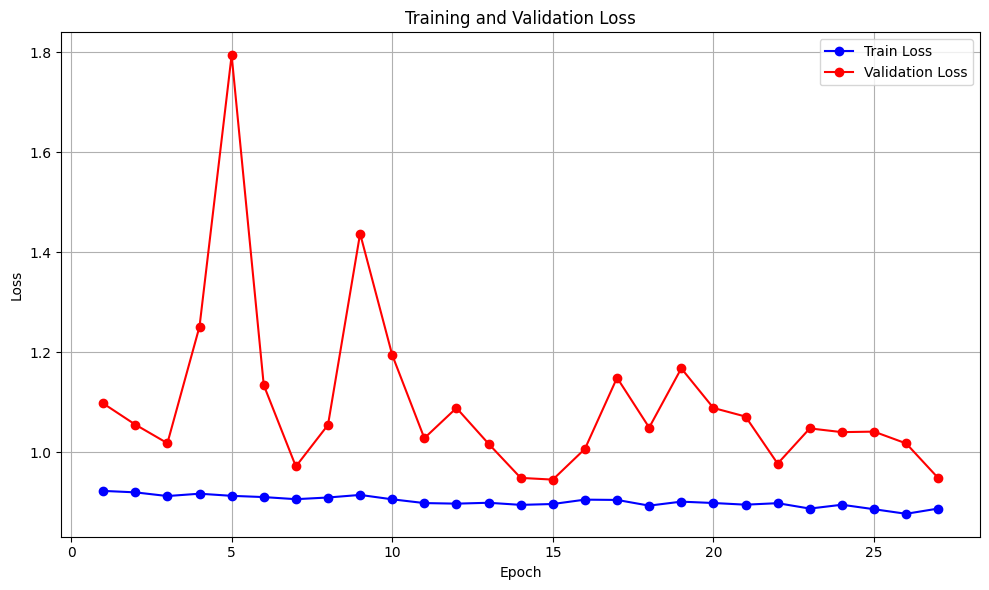

In [50]:
# Load data from CSV into a DataFrame
file_path = save_progress_path  # Replace with your CSV file path
df = pd.read_csv(file_path)

# Plotting the line plot
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train_loss'], marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], marker='o', linestyle='-', color='r', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Sample Predictions

In [ ]:
model.to(DEVICE)
model.eval()
idx = 1995
mask = val_dataset[idx]["mask"].unsqueeze(0)
print("Mask Shape: ",mask.shape)
image = val_dataset[idx]["image"].unsqueeze(0)
print("Image Shape: ",image.shape)
raw_output = model(image.to(DEVICE))
print("raw output shape: ", raw_output.shape)
print("------ Raw Output ------")
print(raw_output)
print("------- Pred Probs -------")
pred_probs = torch.sigmoid(raw_output)
print(pred_probs)
print("------- How does the Mask look like? ------")
print(mask)
print("-------- Predicted Segmentation mask --------")
# binarizer_fn = TripletMaskBinarization(triplets=[[0.7, 600, 0.3]])
# mask = binarizer_fn.transform(mask).float()
# print(segmentation_mask)
segmentation_mask = (pred_probs > 0.4).float()
print(segmentation_mask)

In [ ]:
mask.unique()

In [ ]:
segmentation_mask.unique()

In [ ]:
plt.style.use("classic")

In [ ]:
first_channel_tensor = image[0, 0, :, :]
print(first_channel_tensor.shape)  # torch.Size([512, 512])
second_channel_tensor = image[0, 1, :, :]
print(second_channel_tensor.shape)  # torch.Size([512, 512])
third_channel_tensor = image[0, 2, :, :]
print(third_channel_tensor.shape)  # torch.Size([512, 512])

In [ ]:
plt.title("First Channel Image")
plt.imshow(first_channel_tensor.detach().cpu().numpy(), cmap="gray")

In [ ]:
plt.imshow(mask.squeeze().detach().cpu().numpy(), cmap = 'gray')
print(mask.squeeze().shape)
plt.title("Mask")

In [ ]:
print(segmentation_mask.squeeze().shape)
plt.imshow(segmentation_mask.squeeze().detach().cpu().numpy(), cmap='gray')
plt.title("Segmentation Mask")

In [ ]:
print(type(pred_probs), type(mask))
print(pred_probs.shape, mask.shape)

In [ ]:
print(segmentation_mask.squeeze().squeeze().shape)

In [ ]:
print(mask.squeeze().squeeze().shape)

In [ ]:
# """
# Both methods aim to capture the overlap between predicted positive regions and actual positive regions in the ground truth.
# The dice_metric approach leverages the full range of predicted probabilities, while the  metric function relies on a binary classification based on a chosen threshold.
# """
# Dice = metric(pred_probs.detach().cpu(), mask).item()
# print(f"Dice coefficient: {Dice}")
# dice_metric_score = dice_metric(pred_probs.detach().cpu(), mask)
# print(f"Dice coefficient: {dice_metric_score}")

"""
Both methods aim to capture the overlap between predicted positive regions and actual positive regions in the ground truth.
The dice_metric approach leverages the full range of predicted probabilities, while the  metric function relies on a binary classification based on a chosen threshold.
"""
Dice = metric(segmentation_mask.detach().cpu(), mask).item()
print(f"Dice coefficient: {Dice}")
dice_metric_score = dice_metric(segmentation_mask.squeeze().squeeze().detach().cpu(), mask.squeeze().squeeze(), per_image=False)
print(f"Dice coefficient: {dice_metric_score}")